In [1]:
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding

import paradime as prdm

In [2]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
num_pts = 5000
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:num_pts][np.argsort(mnist.targets[:num_pts])]
testtargets = np.sort(mnist.targets[:num_pts])

In [4]:
dr = prdm.ParametricDR(dataset=testdata,
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=[
            prdm.transforms.PerplexityBasedRescale(
                perplexity=100
            ),
            prdm.transforms.Symmetrize(),
        ]
    ),
    batch_relations=prdm.relations.DifferentiablePDist(
        transform=[
            prdm.transforms.StudentTTransform(alpha=1.),
            prdm.transforms.Normalize(),
            prdm.transforms.ToSquareTensor(),
        ]
    ),
    use_cuda=True,
    verbose=True,
)
dr.add_to_dataset({'pca': PCA(n_components=2).fit_transform(testdata)})
dr.add_training_phase(
    name='pca_init',
    loss=prdm.loss.PositionLoss(
        position_key='pca'
    ),
    batch_size=500,
    n_epochs=10,
)
dr.add_training_phase(
    name='embedding',
    loss=prdm.loss.RelationLoss(
        loss_function=prdm.loss.kullback_leibler_div
    ),
    batch_size=500,
    n_epochs=30,
    report_interval=2,
)
with torch.autograd.set_detect_anomaly(True):
    dr.train()

2022-08-02 16:50:36.0: Registering dataset.
2022-08-02 16:50:36.2: Adding entry 'pca' to dataset.
2022-08-02 16:50:36.2: Computing global relations 'rel'.
2022-08-02 16:50:59.2: Beginning training phase 'pca_init'.
2022-08-02 16:51:01.6: Loss after epoch 0: 21.96171662211418
2022-08-02 16:51:02.8: Loss after epoch 5: 0.19271977432072163
2022-08-02 16:51:03.6: Beginning training phase 'embedding'.
2022-08-02 16:51:04.8: Loss after epoch 0: 3211.621795654297
2022-08-02 16:51:07.2: Loss after epoch 2: 3069.040283203125
2022-08-02 16:51:09.4: Loss after epoch 4: 2886.5947875976562
2022-08-02 16:51:11.8: Loss after epoch 6: 2854.457794189453
2022-08-02 16:51:14.1: Loss after epoch 8: 2904.4844665527344
2022-08-02 16:51:16.3: Loss after epoch 10: 2834.4263916015625
2022-08-02 16:51:18.9: Loss after epoch 12: 2794.778350830078
2022-08-02 16:51:21.2: Loss after epoch 14: 2826.6007080078125
2022-08-02 16:51:23.7: Loss after epoch 16: 2776.1194458007812
2022-08-02 16:51:26.0: Loss after epoch 18

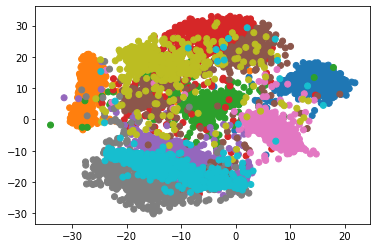

In [5]:
emb = dr.model(testdata.cuda()).detach().cpu()
plt.scatter(
    x=emb[:,0],
    y=emb[:,1],
    c=[ plt.get_cmap('tab10')(t) for t in testtargets ]
)

In [4]:
import seaborn as sns

In [5]:
paradime_colors = {
    "yellow": "#ffcc00",
    "teal": "#144447",
    "cyan": "#23c7a2",
    "red": "#ed3d3d",
    "brown": "#9d6700",
    "purple": "#9a6095",
    "green": "#4c9900", #"#61b60e",
    "orange": "#fd771e",
    "pink": "#f9adc3",
    "grey": "#a1a39d",
    "background": "#fcfcfc",
}
paradime_palette = sns.color_palette(
    [ paradime_colors[i] for i in [
        "teal", "yellow", "cyan", "red", "pink",
        "green", "brown", "grey", "purple", "orange",
    ] ], 10)

In [6]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [7]:
paradime_palette

[(0.0784313725490196, 0.26666666666666666, 0.2784313725490196),
 (1.0, 0.8, 0.0),
 (0.13725490196078433, 0.7803921568627451, 0.6352941176470588),
 (0.9294117647058824, 0.23921568627450981, 0.23921568627450981),
 (0.9764705882352941, 0.6784313725490196, 0.7647058823529411),
 (0.2980392156862745, 0.6, 0.0),
 (0.615686274509804, 0.403921568627451, 0.0),
 (0.6313725490196078, 0.6392156862745098, 0.615686274509804),
 (0.6039215686274509, 0.3764705882352941, 0.5843137254901961),
 (0.9921568627450981, 0.4666666666666667, 0.11764705882352941)]

In [8]:
plt.rcParams['axes.facecolor'] = paradime_colors['background']
plt.rcParams['savefig.facecolor'] = paradime_colors['background']

In [11]:
emb2 = dr.model.embed((mnist.data.reshape(-1, 28*28) / 255.).cuda()).detach().cpu()

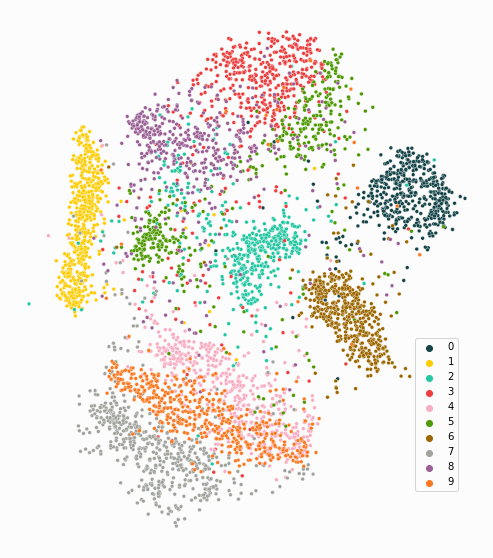

In [12]:
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

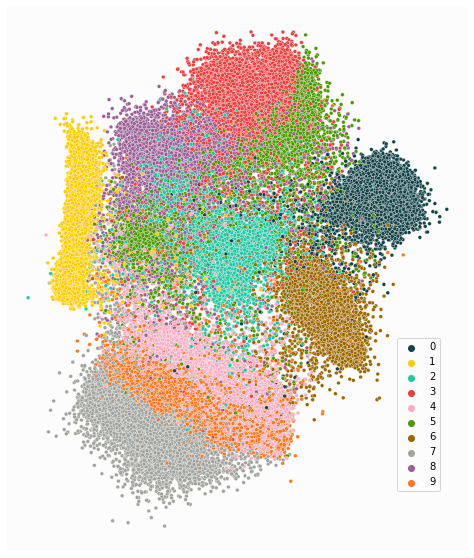

In [13]:
plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=mnist.targets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [26]:
foo = prdm.routines.ParametricTSNE(
    perplexity=100,
    dataset=testdata,
    init_epochs=5,
    epochs=30,
    batch_size=100,
    use_cuda=True,
    verbose=True
)

2022-08-02 17:42:46.7: Registering dataset.


In [27]:
foo.train()

2022-08-02 17:42:48.8: Adding entry 'pca' to dataset.
2022-08-02 17:42:48.8: Computing global relations 'rel'.
2022-08-02 17:42:56.2: Beginning training phase 'pca_init'.
2022-08-02 17:42:58.3: Loss after epoch 0: 25.06684535741806
2022-08-02 17:42:58.8: Beginning training phase 'embedding'.
2022-08-02 17:42:59.4: Loss after epoch 0: 3214.400909423828
2022-08-02 17:43:02.3: Loss after epoch 5: 2953.305145263672
2022-08-02 17:43:05.2: Loss after epoch 10: 2852.391357421875
2022-08-02 17:43:08.2: Loss after epoch 15: 2850.5586547851562
2022-08-02 17:43:11.1: Loss after epoch 20: 2735.4146728515625
2022-08-02 17:43:14.0: Loss after epoch 25: 2729.0034790039062


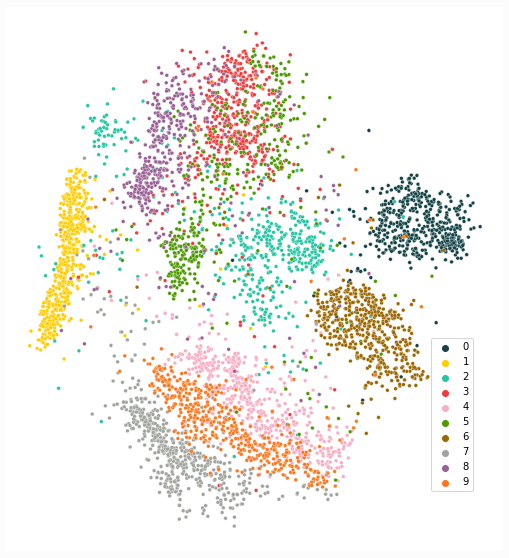

In [28]:
emb = foo(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

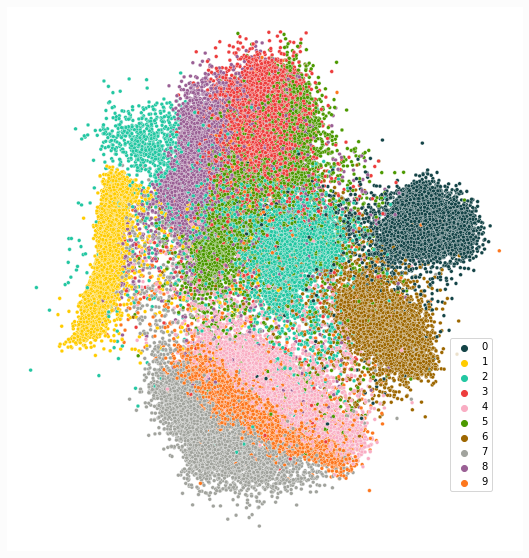

In [29]:
emb2 = foo.model((mnist.data.reshape(-1, 28*28) / 255.).cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=mnist.targets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

In [53]:
def cross_entropy_loss_2(p, q, epsilon = 1.0e-4):
    a = -1. * p * torch.log(q  + epsilon)
    b = (p - 1.) * torch.log(1 - q + epsilon)
    return torch.sum(a + b)

In [62]:
dr = prdm.ParametricDR(dataset=testdata,
    global_relations=prdm.relations.NeighborBasedPDist(
        transform=[
            prdm.transforms.ConnectivityBasedRescale(
                n_neighbors=600
            ),
            prdm.transforms.Symmetrize(subtract_product=True),
        ]
    ),
    batch_relations=prdm.relations.DistsFromTo(
        transform=[
            prdm.transforms.ModifiedCauchyTransform(
                min_dist=0.5, spread=0.5)
        ]
    ),
    use_cuda=True,
    verbose=True,
)
dr._compute_global_relations()
dr.add_to_dataset({
    'spectral': (lambda emb: (emb - emb.mean(axis=0))/emb.std(axis=0))(
        SpectralEmbedding(affinity='precomputed').fit_transform(
            dr.global_relation_data['rel'].to_square_array().data)
    )
})
dr.add_training_phase(
    name='spectral_init',
    loss=prdm.loss.PositionLoss(
        position_key='spectral'
    ),
    batch_size=500,
    n_epochs=5,
)
dr.add_training_phase(
    name='embedding',
    sampling='negative_edge',
    neg_sampling_rate=1,
    loss=prdm.loss.RelationLoss(
        loss_function=cross_entropy_loss_2
    ),
    batch_size=250,
    learning_rate=0.001,
    n_epochs=30,
    report_interval=2,
)
with torch.autograd.set_detect_anomaly(True):
    dr.train()

2022-08-02 19:39:00.9: Registering dataset.
2022-08-02 19:39:00.9: Computing global relations 'rel'.
2022-08-02 19:39:21.1: Adding entry 'spectral' to dataset.
2022-08-02 19:39:21.1: Computing global relations 'rel'.
2022-08-02 19:39:39.2: Beginning training phase 'spectral_init'.
2022-08-02 19:39:39.4: Loss after epoch 0: 8.29769092798233
2022-08-02 19:39:40.4: Beginning training phase 'embedding'.
2022-08-02 19:39:42.2: Loss after epoch 0: 3122.4944763183594
2022-08-02 19:39:45.7: Loss after epoch 2: 2575.1966552734375
2022-08-02 19:39:49.3: Loss after epoch 4: 2424.639434814453
2022-08-02 19:39:52.9: Loss after epoch 6: 2398.7635192871094
2022-08-02 19:39:56.3: Loss after epoch 8: 2273.1758880615234
2022-08-02 19:39:59.8: Loss after epoch 10: 2183.147979736328
2022-08-02 19:40:03.2: Loss after epoch 12: 2155.184326171875
2022-08-02 19:40:06.7: Loss after epoch 14: 2130.2823791503906
2022-08-02 19:40:10.2: Loss after epoch 16: 2254.4928588867188
2022-08-02 19:40:13.7: Loss after epoc

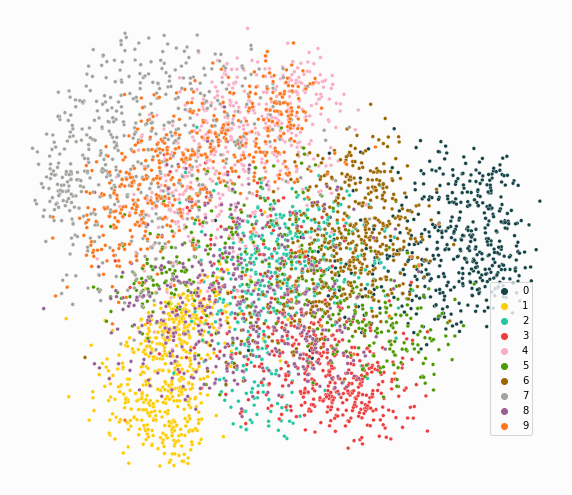

In [63]:
emb = dr(testdata.cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=testtargets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))

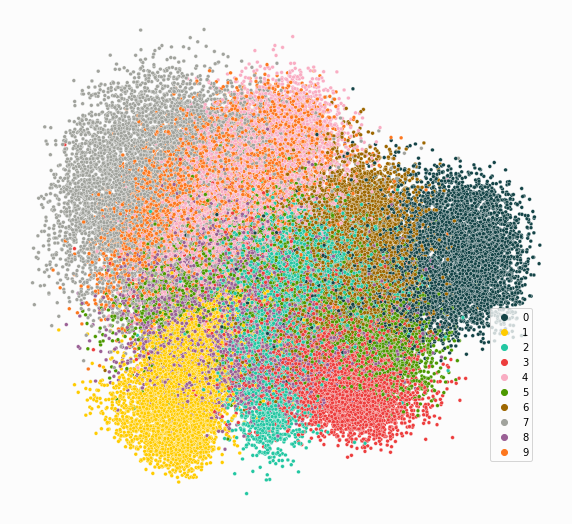

In [64]:
emb2 = dr.model((mnist.data.reshape(-1, 28*28) / 255.).cuda()).detach().cpu()
fig = plt.figure(figsize=(10,10))
fig.set_facecolor(paradime_colors['background'])
sp = sns.scatterplot(x=emb2[:,0], y=emb2[:,1], hue=mnist.targets,
    s=14., alpha=1., edgecolor="white",  palette=paradime_palette)
sp.tick_params(bottom=False, left=False)
sp.set(xticklabels=[],yticklabels=[], aspect=1.)
sns.despine(top=True, left=True, bottom=True, right=True)
sns.move_legend(sp, "lower right", bbox_to_anchor=(.95,0.1))